In [1]:
!pip install --upgrade pip
!pip install python-binance
!pip install data_cache

# Option valuation model based on historical prices

In [1]:
import importlib.util
import os
google_colab_spec = importlib.util.find_spec("google") and importlib.util.find_spec("google.colab")
if google_colab_spec:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path = '/content/drive/MyDrive/Colab Notebooks/Ethereum Prices'
else:
    path = f'{os.environ["HOME"]}/Library/CloudStorage/GoogleDrive-chris.perso@gmail.com/My Drive/Colab Notebooks/Ethereum Prices'
    
os.environ['CACHE_PATH'] = path
os.environ['DISABLE_CACHE'] = 'FALSE'

from datetime import datetime, timedelta, date
import pandas
import binance
import numpy
from numpy import ndarray
from matplotlib import pyplot
import math
import requests
from typing import Tuple

COUNT_YEARS = 10
BINANCE_DATETIME_FORMAT = "%Y-%m-%d %H-%M-%S"
BINANCE_SYMBOL = 'ETHUSDT'


def first_day_of_next_month(year: int, month: int) -> datetime:
    """Returns the first datetime of the next month.
    
    Args:
    year: The year.
    month: The month.
    
    Returns:
    A datetime object representing the first day of the next month.
    """
    
    next_month = month + 1
    if next_month > 12:
        next_month = 1
        year += 1
    return datetime(year, next_month, 1)


def load_prices_by_month(code: str, year: int, month: int, force_refresh: bool=False) -> pandas.DataFrame:
    target_path = f'{path}/{BINANCE_SYMBOL}/{year}'
    target_filename = f'{target_path}/{year}-{month:02d}.csv.zip'
    if os.path.exists(target_filename) and not force_refresh:
        binance_prices = pandas.read_csv(target_filename, compression='infer', header=0)
    else:
        print(f'no previous data found in {target_path}, loading from binance')
        binance_client = binance.Client()
        from_date = datetime(year, month, 1, 0, 0, 0)
        until_date = first_day_of_next_month(year, month) - timedelta(seconds=1)
        
        candles = binance_client.get_historical_klines(code, binance.Client.KLINE_INTERVAL_1HOUR, str(from_date), str(until_date))
        binance_prices = pandas.DataFrame(candles, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
                                              'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol',
                                              'ignore'])
        os.makedirs(target_path, exist_ok=True)
        binance_prices.to_csv(target_filename, index=False, compression="zip")
    
    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    binance_prices['open'] = binance_prices['open'].astype(float)
    binance_prices['high'] = binance_prices['high'].astype(float)
    binance_prices['low'] = binance_prices['low'].astype(float)
    binance_prices['close'] = binance_prices['close'].astype(float)
    binance_prices['volume'] = binance_prices['volume'].astype(float)
    binance_prices.dateTime = pandas.to_datetime(binance_prices.dateTime, unit='ms')
    binance_prices.set_index('dateTime', inplace=True)
    return binance_prices

current_year = datetime.now().year
df_by_period = list()
for year in range(current_year - COUNT_YEARS, current_year + 1):
    print(f'\nloading {year}', end=' ')
    for month in range(1, 13):
        if year == current_year and month == datetime.today().month:
            print(f'\ninterrupting at {year}/{month:02d}')
            break
        print('.', end='')
        df = load_prices_by_month(BINANCE_SYMBOL, year, month)
        df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'], axis=1)
        df_by_period.append(df)

prices_df = pandas.concat(df_by_period, axis=0)
prices_df.index = pandas.to_datetime(prices_df.index)

daily_prices = prices_df.groupby(prices_df.index.date)['open'].first()


loading 2014 ............
loading 2015 ............
loading 2016 ............
loading 2017 ............
loading 2018 ............
loading 2019 ............
loading 2020 ............
loading 2021 ............
loading 2022 ............
loading 2023 ............
loading 2024 
interrupting at 2024/01


## Option valuation model: input parameters here

In [6]:
target_period_days = 9
CUT_OFF_YEAR = 2020

instrument_code = BINANCE_SYMBOL[:3]

headers = {"Content-Type": "application/json"}
base_url = 'https://www.deribit.com/api/v2/public'

get_options = f"{base_url}/get_instruments?currency={instrument_code}&kind=option&expired=false"
response_options = requests.get(get_options, headers=headers)
if response_options.status_code != 200:
    raise IOError(f'request failed with error {response_options.status_code}')

result = response_options.json()['result']
puts = {}
calls = {}
for option in result:
    if option['option_type'] == 'put':
        puts[(option['strike'], datetime.fromtimestamp(option['expiration_timestamp'] / 1000).date())] = option['instrument_id']
    elif option['option_type'] == 'call':
        calls[(option['strike'], datetime.fromtimestamp(option['expiration_timestamp'] / 1000).date())] = option['instrument_id']

target_expiry = min({k[1] for k in puts.keys()}, key=lambda d: abs(d - (date.today() + timedelta(days=target_period_days))))

get_current_price = f"{base_url}/get_index_price?index_name={instrument_code.lower()}_usd"
response_current_price = requests.get(get_current_price, headers=headers)

if response_current_price.status_code != 200:
    raise IOError(f'request failed with error {response_current_price.status_code}')

current_price = response_current_price.json()['result']['index_price']
remaining_days = (target_expiry - date.today()).days
rolling_min_series = prices_df.groupby(prices_df.index.date)['low'].min().rolling(remaining_days).min()
period_close_series = prices_df.groupby(prices_df.index.date)['close'].last().shift(-remaining_days)
period_close_dates = prices_df.groupby(prices_df.index.date)['close'].last().shift(-remaining_days).index
df = pandas.DataFrame({
    'daily_prices': daily_prices,
    'period_close_series': period_close_series,
    'rolling_min_series': rolling_min_series
})
df['rolling_min_series'] = df['rolling_min_series'].shift(-remaining_days)
df['drawdown_pct'] = -df['rolling_min_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df['period_perf_pct'] = df['period_close_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df.dropna(inplace=True)
df.index = pandas.to_datetime(df.index)

frequencies = dict()
for loss in range(5, 80, 5):
    frequencies[-loss] = 100. * df['drawdown_pct'][df['drawdown_pct'] > loss].count() / df['drawdown_pct'].count()

df = df[df.index.year>=CUT_OFF_YEAR]

def generate_strikes(price: float):
    if price <= 10000:
        step = 100.
    else:
        step = 500.
        
    closest_hundred = round(price / step) * step
    strikes = set()
    strikes.add(closest_hundred)
    for i in range(1, 3):
        strikes.add(closest_hundred + i * step)
        strikes.add(closest_hundred - i * step)

    return strikes

def load_bid_ask(options, strike: float, expiry: date) -> Tuple[float, float]:
    instrument_id = options[(strike, expiry)]
    get_bid_ask = f"{base_url}/get_order_book_by_instrument_id?instrument_id={instrument_id}&depth=1"
    response_bid_ask = requests.get(get_bid_ask, headers=headers)

    if response_bid_ask.status_code != 200:
        raise IOError(f'request failed with error {response_bid_ask.status_code}')

    bid_ask = response_bid_ask.json()['result']
    bid = ask = None
    if 'bids' in bid_ask and bid_ask['bids'] and bid_ask['bids'][0] and bid_ask['bids'][0][0]:
        bid = bid_ask['bids'][0][0]
    if 'asks' in bid_ask and bid_ask['asks'] and bid_ask['asks'][0] and bid_ask['asks'][0][0]:
        ask = bid_ask['asks'][0][0]
    return bid, ask

strike_prices = list(generate_strikes(current_price))
for count, strike_price in enumerate(strike_prices, start=1):
    strike_factor = strike_price / current_price
    df[f'strike_{count}'] = df['daily_prices'].multiply(strike_factor)
    df[f'strike_pct_{count}'] = strike_factor

    df[f'call_value_{count}'] = df['period_close_series'].subtract(df[f'strike_{count}'])
    df[f'call_value_{count}'].loc[df[f'call_value_{count}'] < 0.] = 0.
    df[f'call_value_pct_{count}'] = df[f'call_value_{count}'].divide(df['daily_prices'])

    df[f'put_value_{count}'] = df[f'strike_{count}'].subtract(df['period_close_series'])
    df[f'put_value_{count}'].loc[df[f'put_value_{count}'] < 0.] = 0.
    df[f'put_value_pct_{count}'] = df[f'put_value_{count}'].divide(df['daily_prices'])


option_chain = list()
for count, strike_price in enumerate(strike_prices, start=1):
    put_bid, put_ask = load_bid_ask(puts, strike_price, target_expiry)
    call_bid, call_ask = load_bid_ask(calls, strike_price, target_expiry)
    strike_data = {
        'strike': strike_price,
        'value_call': df[f'call_value_pct_{count}'].mean() * current_price,
        'value_put': df[f'put_value_pct_{count}'].mean() * current_price,
        'value_call_median': df[f'call_value_pct_{count}'].quantile(0.5) * current_price,
        'value_put_median': df[f'put_value_pct_{count}'].quantile(0.5) * current_price,
        'value_call_pct': df[f'call_value_pct_{count}'].mean(),
        'call_ask': call_ask,
        'value_put_pct': df[f'put_value_pct_{count}'].mean(),
        'put_ask': put_ask
    }
    if strike_price < current_price:
        strike_data['value_call_pct'] = None
    if strike_price > current_price:
        strike_data['value_put_pct'] = None

    option_chain.append(strike_data)

option_chain_df = pandas.DataFrame(option_chain).set_index('strike').sort_index()

#
index_put = 1
index_call = -2
#
cost, value = (option_chain_df.iloc[index_put]['put_ask'] + option_chain_df.iloc[index_call]['call_ask'], 
 option_chain_df.iloc[index_put]['value_put_pct'] + option_chain_df.iloc[index_call]['value_call_pct']
)
print(f'trading put {option_chain_df.iloc[index_put].name:.0f} and call {option_chain_df.iloc[index_call].name:.0f}')
print(f'cost: {cost:.2f} / value: {value:.2f}')

option_chain_df

trading put 2100 and call 2300
cost: 0.04 / value: 0.08


,value_call,value_put,value_call_median,value_put_median,value_call_pct,call_ask,value_put_pct,put_ask
strike,,,,,,,,
2000.0,306.518632,34.651744,248.794259,0.000000,NaN,0.1135,0.015764,0.0095
2100.0,227.710691,55.843803,148.794259,0.000000,NaN,0.0695,0.025404,0.0180
2200.0,162.169836,90.302947,48.794259,0.000000,0.073774,0.0355,NaN,0.0340
2300.0,112.589763,140.722874,0.000000,51.205741,0.051219,0.0175,NaN,0.0660
2400.0,76.887684,205.020796,0.000000,151.205741,0.034978,0.0085,NaN,0.1025


# Some statistics

In [5]:
df['daily_prices'].describe()

count    1444.000000
mean     1707.560478
std      1113.609879
min       107.670000
25%       656.977500
50%      1665.895000
75%      2237.577500
max      4807.980000
Name: daily_prices, dtype: float64

<Axes: title={'center': 'Historical prices ETH'}>

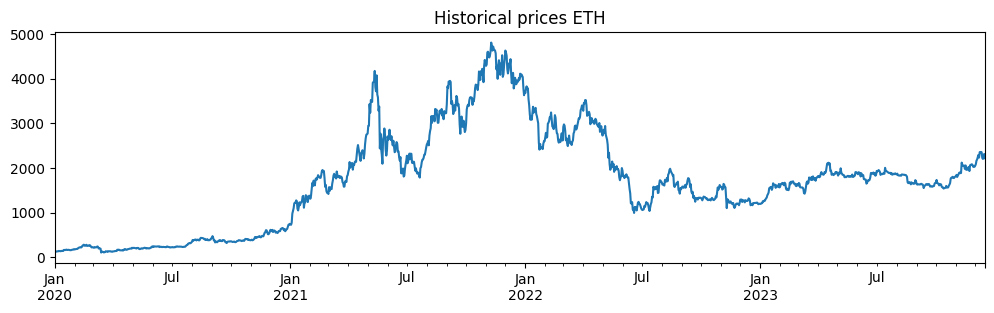

In [4]:
df['daily_prices'].plot(figsize=(12,3), title=f"Historical prices {instrument_code}")

## Draw-down probability (intraday data)

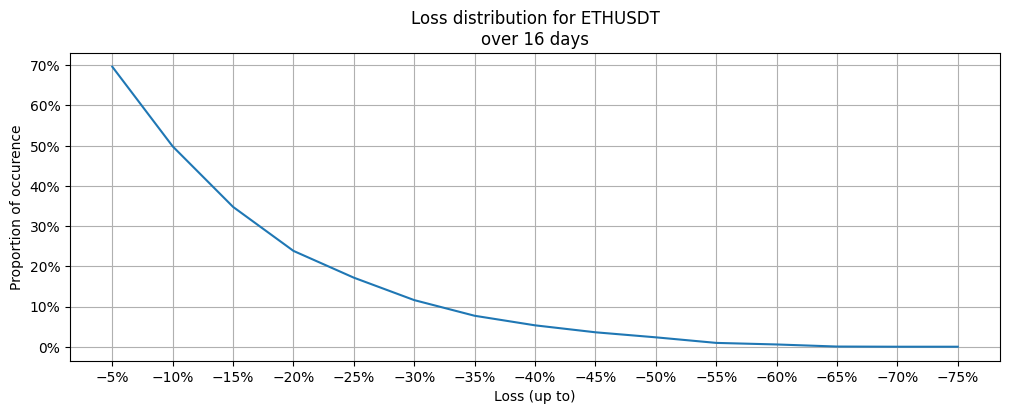

In [10]:
from matplotlib import ticker
axes = pandas.Series(frequencies, name='loss_distribution').plot(
    figsize=(12,4),
    grid=True,
    xticks=list(frequencies.keys()),
    title=f'Loss distribution for {BINANCE_SYMBOL}\nover {remaining_days} days'
)
pyplot.gca().invert_xaxis()
pyplot.xlabel('Loss (up to)')
pyplot.ylabel('Proportion of occurence')
axes.xaxis.set_major_formatter(ticker.PercentFormatter())
axes.yaxis.set_major_formatter(ticker.PercentFormatter())

## Performance distribution

Text(0.5, 1.0, 'Period (16 days) Performance Underlying')

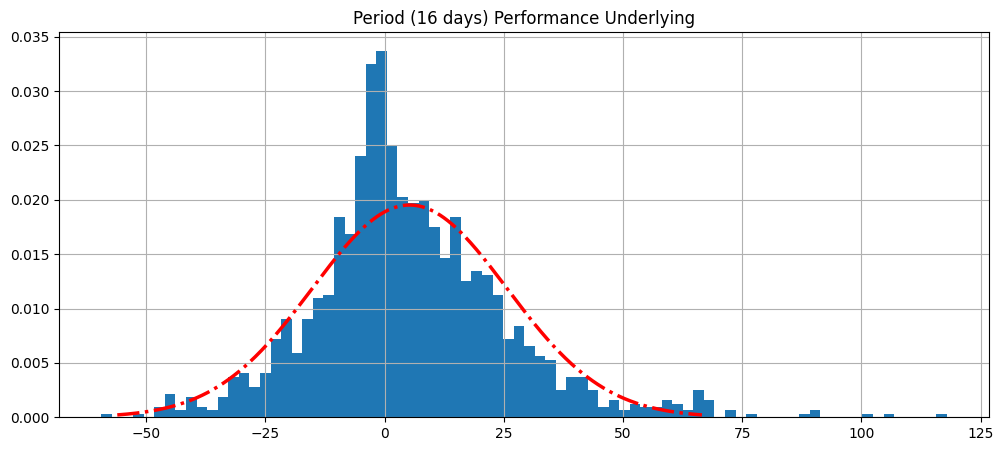

In [11]:
df['period_perf_pct'].hist(bins=80, density=True, figsize=(12, 5))

def normpdf(x: ndarray, mu: float, sigma: float):
    sigma = abs(float(sigma))
    z = (x - float(mu)) / sigma
    return numpy.exp(-0.5 * numpy.square(z)) / (math.sqrt(2. * math.pi) * sigma)

mu = df['period_perf_pct'].describe()['mean']
sigma = df['period_perf_pct'].describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
y = normpdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title(f'Period ({remaining_days} days) Performance Underlying')

Text(0.5, 1.0, 'Daily Performance Underlying')

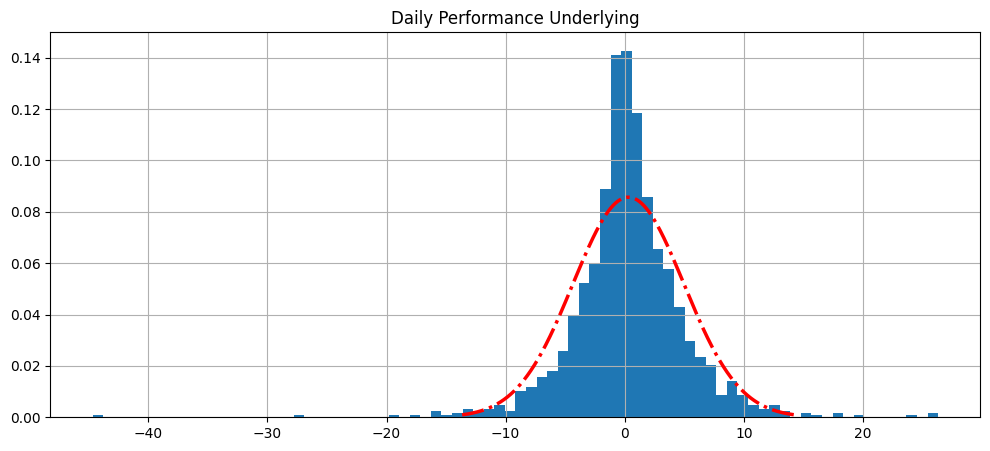

In [12]:
daily_perf = df["daily_prices"].shift(-1).divide(df["daily_prices"]).subtract(1.).dropna().multiply(100.)
daily_perf.hist(bins=80, density=True, figsize=(12, 5))

mu = daily_perf.describe()['mean']
sigma = daily_perf.describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = normpdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title('Daily Performance Underlying')

<Axes: >

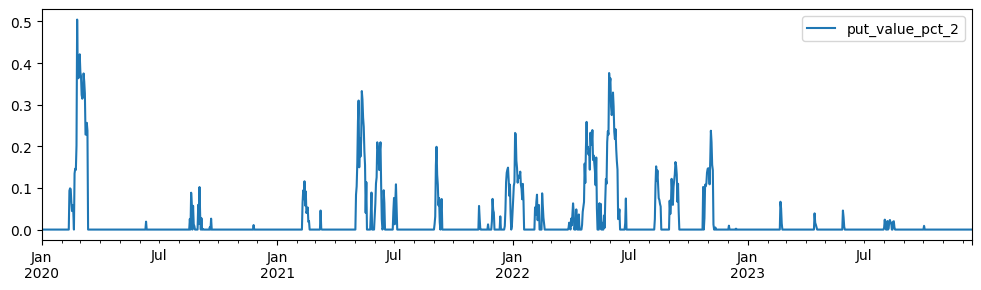

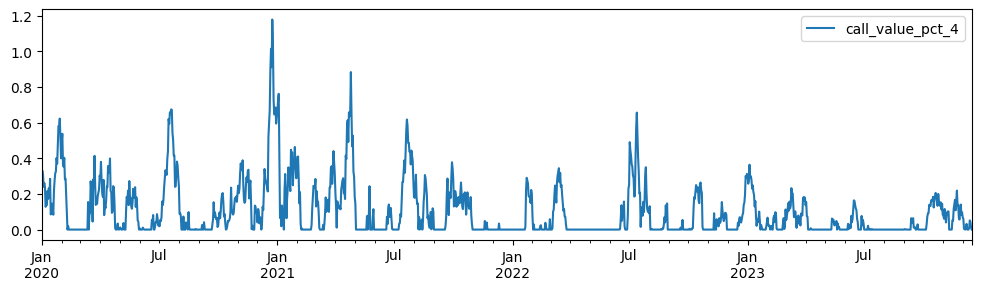

In [13]:
df[['put_value_pct_2']].plot(figsize=(12,3))
df[['call_value_pct_4']].plot(figsize=(12,3))


In [3]:
prices_df.tail()

,open,high,low,close,volume
dateTime,,,,,
2023-12-31 19:00:00,2303.20,2304.34,2291.14,2294.83,6990.5732
2023-12-31 20:00:00,2294.83,2294.83,2280.28,2282.40,12876.9660
2023-12-31 21:00:00,2282.40,2292.75,2280.11,2283.20,7392.8667
2023-12-31 22:00:00,2283.21,2293.99,2258.88,2274.77,18374.1473
2023-12-31 23:00:00,2274.76,2284.42,2272.49,2281.87,10288.4085
